# Imports

In [1]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 94.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 101.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 95.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.7/832.7 kB 85.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 90.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 97.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 75.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 101.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 101.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 94.6 MB/s  0:00:00m eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.0
    Uninstalling numpy-2.4.0:
      Successfully uninstalled numpy-2.4.0━━━━━━━━━━━━━━━━━━━━━━━━  2/15 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dtw import dtw
from pyts.datasets import load_coffee, ucr_dataset_list, fetch_ucr_dataset
from collections import Counter
import time

from abba import ABBA, ABBA_like, ABBAPatched
from models.LSTM import TimeSeriesLSTM
from train.train_LSTM import train_lstm, train_lstm_rolling
from models.ABBA_LSTM import ABBALSTM
from train.train_ABBALSTM import train_abba, train_abba_rolling
from utils.data_handler import resample_to_horizon
from utils.metrics import smape

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Sin wave tests

## ABBA transformation and reconstruction

In [3]:
np.random.seed(42)
torch.manual_seed(42)

N = 200
t = np.linspace(0, 20, N)
series = np.sin(t) #+ 0.1 * np.random.randn(N)

dtw = 15.457918803904526


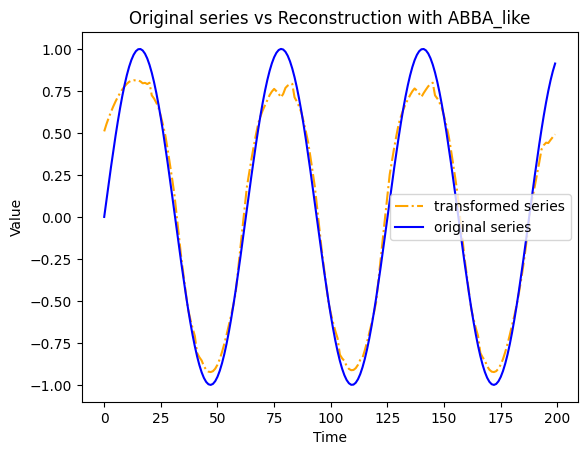

In [4]:
n_symbols = 12
window_size = 20

abba_like = ABBA_like(n_symbols=n_symbols, window_size=window_size)
symbol_sequence = abba_like.fit(series)
recon_smooth = abba_like.inverse_transform_smooth(symbol_sequence)
plt.plot(recon_smooth, label='transformed series', color='orange', linestyle='-.')
plt.plot(series, label='original series', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original series vs Reconstruction with ABBA_like')
plt.legend(loc='best')

print('dtw =', dtw(series, recon_smooth, keep_internals=False).distance)

dtw = 11.713959588249205


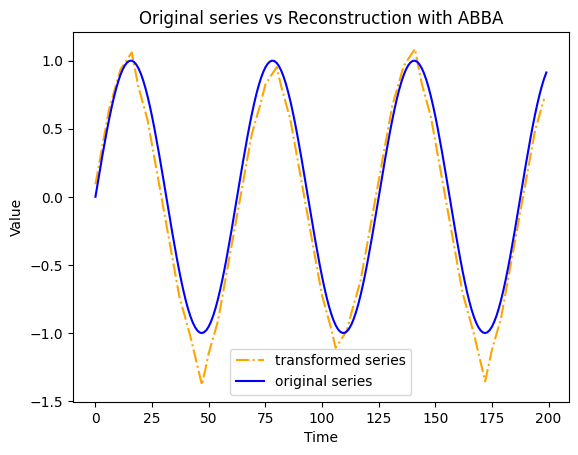

In [5]:
abba = ABBA(n_symbols=10)
symbol_sequence = abba.fit(series)
recon = abba.inverse_transform(symbol_sequence, series[0])
plt.plot(recon, label='transformed series', color='orange', linestyle='-.')
plt.plot(series, label='original series', color='blue')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original series vs Reconstruction with ABBA')

print('dtw =', dtw(series, recon, keep_internals=False).distance)

In [6]:
print(abba.symbol_map)
print(abba.symbol_sequence)

{0: array([1.        , 0.05815302]), 1: array([5.        , 0.02536656]), 2: array([ 3.        , -0.08494644]), 3: array([ 2.        , -0.07156599]), 4: array([ 1.        , -0.09238321]), 5: array([1.        , 0.09173036]), 6: array([3.        , 0.07742357]), 7: array([2.        , 0.06666672]), 8: array([ 1.       , -0.0602448]), 9: array([ 5.        , -0.07002806])}
[5 5 5 5 5 5 5 0 0 0 0 0 1 2 8 8 8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 8 8 8 8 8
 9 6 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 7 1 3 8 8 8 8 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 8 8 8 8 3 1 7 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0
 0 0 1 2 8 8 8 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 8 8 8 8 8 9 6 0 0 0 0 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0]



dtw = 8.081095086461938


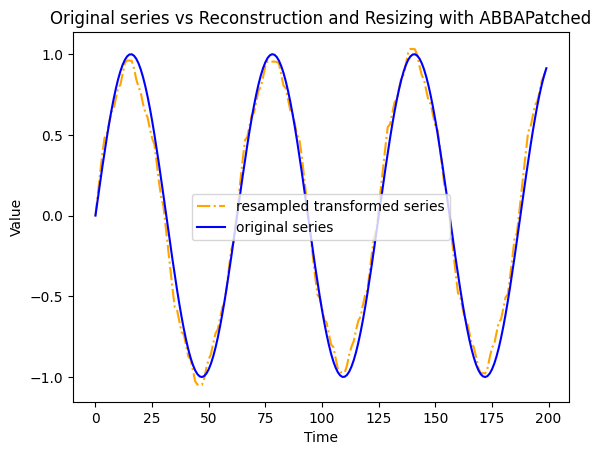

In [7]:
abba_patched = ABBAPatched(compression_tol=0.01, alpha=0.2, max_k=10)
symbol_sequence = abba_patched.fit(series)
recon_patched = abba_patched.inverse_transform(symbol_sequence, series[0])
recon_patched_resampled = resample_to_horizon(
    recon_patched,
    len(series)
)
plt.plot(recon_patched_resampled, label='resampled transformed series', color='orange', linestyle='-.')
plt.plot(series, label='original series', color='blue')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original series vs Reconstruction and Resizing with ABBAPatched')
print()
print('dtw =', dtw(series, recon_patched_resampled, keep_internals=False).distance)

In [8]:
print(abba_patched.symbol_sequence)

[0 1 1 1 2 3 3 3 4 5 3 3 3 2 1 1 1 6 7 1 1 1 2 2 3 3 3 8 3 3 3 2 1 1 1 6 7
 1 1 1 2 3 3 3 4 5 3 3 3 2 1 1 1 6 7 1 1 9]


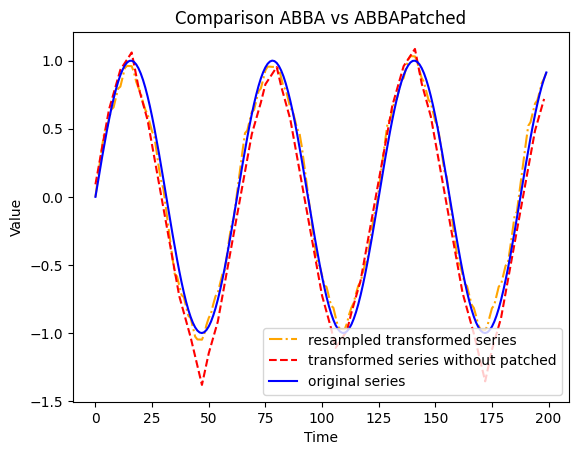

In [9]:
plt.plot(recon_patched_resampled, label='resampled transformed series', color='orange', linestyle='-.')
plt.plot(recon, label='transformed series without patched', color='red', linestyle='--')
plt.plot(series, label='original series', color='blue')
plt.legend(loc='best')
plt.title('Comparison ABBA vs ABBAPatched')
plt.xlabel('Time')
plt.ylabel('Value')

print()

## LSTM Prediction

In [10]:
model = TimeSeriesLSTM(hidden_sizes=[50, 50], lag=10)
train_lstm_rolling(model, series, device='cuda', val_size=30, lr=0.0005, epochs=300, patience=20)
print()

Epoch [10/300] Train: 0.214259 Val: 0.140572
Epoch [20/300] Train: 0.111457 Val: 0.187732
Epoch [30/300] Train: 0.066651 Val: 0.111270
Epoch [40/300] Train: 0.005681 Val: 0.006685
Epoch [50/300] Train: 0.001339 Val: 0.001447
Epoch [60/300] Train: 0.000418 Val: 0.000501
Epoch [70/300] Train: 0.000154 Val: 0.000194
Epoch [80/300] Train: 0.000065 Val: 0.000086
Epoch [90/300] Train: 0.000036 Val: 0.000052
Epoch [100/300] Train: 0.000025 Val: 0.000044
Epoch [110/300] Train: 0.000021 Val: 0.000041
Epoch [120/300] Train: 0.000019 Val: 0.000039
Epoch [130/300] Train: 0.000017 Val: 0.000038
Epoch [140/300] Train: 0.000016 Val: 0.000035
Epoch [150/300] Train: 0.000014 Val: 0.000033
Epoch [160/300] Train: 0.000013 Val: 0.000031
Epoch [170/300] Train: 0.000012 Val: 0.000029
Epoch [180/300] Train: 0.000012 Val: 0.000026
Epoch [190/300] Train: 0.000011 Val: 0.000025
Epoch [200/300] Train: 0.000010 Val: 0.000023
Epoch [210/300] Train: 0.000121 Val: 0.000063
Epoch [220/300] Train: 0.000010 Val: 0.0000

/tmp/ipykernel_1765/1585280178.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  forecast = np.array(forecast)


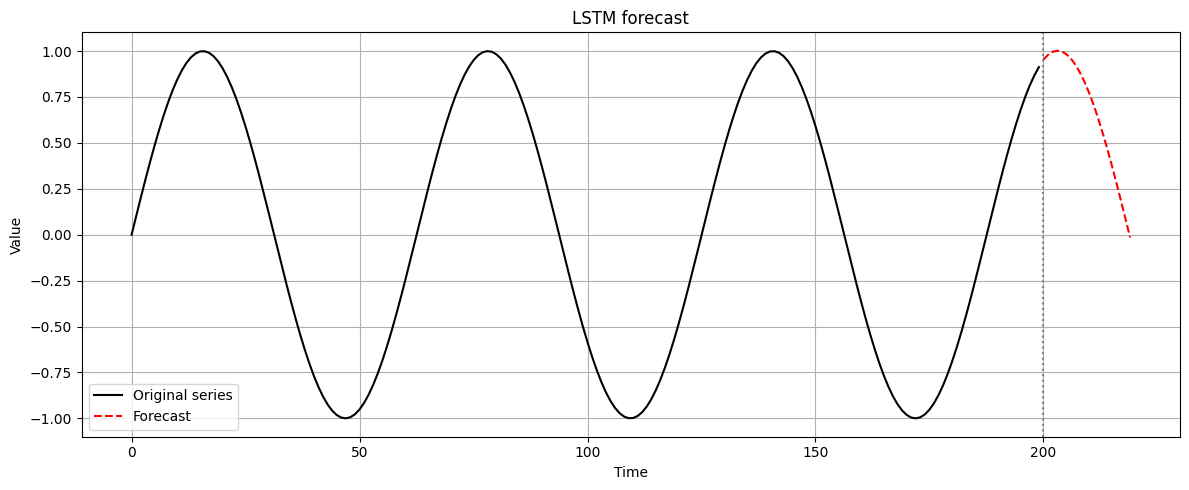

In [11]:
forecast = model.forecast(torch.tensor(series, dtype=torch.float), horizon=20)

series = np.array(series)
forecast = np.array(forecast)

N = len(series)
H = len(forecast)

plt.figure(figsize=(12, 5))

plt.plot(range(N), series, label="Original series", color="black")
plt.plot(range(N, N + H), forecast, label="Forecast", color="red", linestyle='--')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("LSTM forecast")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

plt.axvline(len(series), color="gray", linestyle=":")
plt.show()

## ABBA-LSTM Prediction

In [12]:
abba_patched = ABBAPatched(compression_tol=0.01, alpha=0.5, max_k=10)
symbol_sequence = abba_patched.fit(series)

In [13]:
symbol_sequence

array([0, 1, 1, 1, 2, 3, 3, 3, 4, 5, 3, 3, 3, 2, 1, 1, 1, 6, 7, 1, 1, 1,
       2, 2, 3, 3, 3, 8, 3, 3, 3, 2, 1, 1, 1, 6, 7, 1, 1, 1, 2, 3, 3, 3,
       4, 5, 3, 3, 3, 2, 1, 1, 1, 6, 7, 1, 1, 9])

In [14]:
n_symbols = abba_patched.n_symbols
model = ABBALSTM(n_symbols, hidden_sizes=[50, 50], lag=3)
train_abba_rolling(model, symbol_sequence, device='cuda', epochs=300, lr=0.0005, patience=20, val_size=30)
print()

Epoch [10/300] Train: 2.302513 Val: 2.273143
Epoch [20/300] Train: 2.253804 Val: 2.232552
Epoch [30/300] Train: 2.189097 Val: 2.178172
Epoch [40/300] Train: 2.090345 Val: 2.097712
Epoch [50/300] Train: 1.935255 Val: 1.980893
Epoch [60/300] Train: 1.726919 Val: 1.848640
Epoch [70/300] Train: 1.533317 Val: 1.757620


Epoch [80/300] Train: 1.388770 Val: 1.678258
Epoch [90/300] Train: 1.254613 Val: 1.559986
Epoch [100/300] Train: 1.126924 Val: 1.425383
Epoch [110/300] Train: 1.006359 Val: 1.297975
Epoch [120/300] Train: 0.897069 Val: 1.188410
Epoch [130/300] Train: 0.806838 Val: 1.104760
Epoch [140/300] Train: 0.734478 Val: 1.036196
Epoch [150/300] Train: 0.675138 Val: 0.978411
Epoch [160/300] Train: 0.621645 Val: 0.925304
Epoch [170/300] Train: 0.571166 Val: 0.870808
Epoch [180/300] Train: 0.525152 Val: 0.819416
Epoch [190/300] Train: 0.485256 Val: 0.777286
Epoch [200/300] Train: 0.451620 Val: 0.743276
Epoch [210/300] Train: 0.424131 Val: 0.716180
Epoch [220/300] Train: 0.401601 Val: 0.693712
Epoch [230/300] Train: 0.382892 Val: 0.675291
Epoch [240/300] Train: 0.367341 Val: 0.660360
Epoch [250/300] Train: 0.354349 Val: 0.648413
Epoch [260/300] Train: 0.343466 Val: 0.639076
Epoch [270/300] Train: 0.334352 Val: 0.631770
Epoch [280/300] Train: 0.326710 Val: 0.626008
Epoch [290/300] Train: 0.320271 Val:

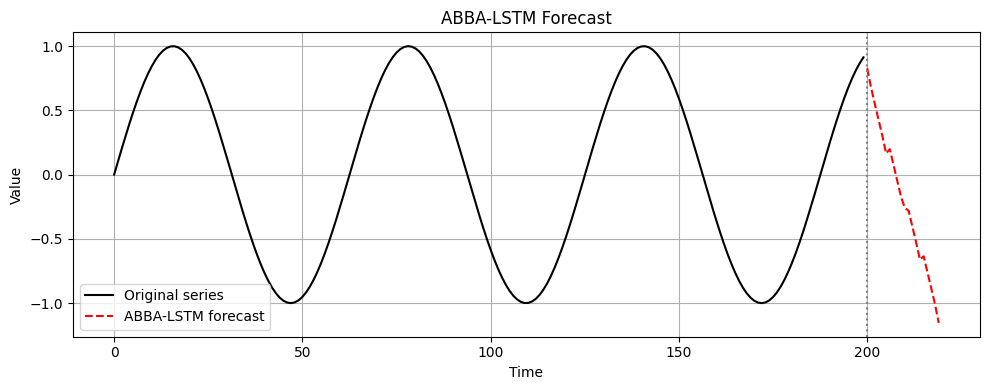

In [15]:
symbols_forecast = model.forecast(
    torch.tensor(symbol_sequence, dtype=torch.long),
    horizon=20
)
numeric_forecast = abba.inverse_transform(symbols_forecast, series[-1])
numeric_forecast_resampled = resample_to_horizon(numeric_forecast, 20)

plt.figure(figsize=(10, 4))

# Série originale
plt.plot(
    np.arange(len(series)),
    series,
    label="Original series",
    color="black"
)

# Forecast
plt.plot(
    np.arange(len(series), len(series) + len(numeric_forecast_resampled)),
    numeric_forecast_resampled,
    label="ABBA-LSTM forecast",
    color="red",
    linestyle="--"
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.axvline(len(series), color="gray", linestyle=":")
plt.legend()
plt.title("ABBA-LSTM Forecast")
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 10

In [10]:
N = 1000
frequencies = range(1, 101)
c = 50
n_layers = 2
lag_lstm = 50
lag_abba = 5
p = 50
lr = 0.001
horizon = 200
stateful = False
# tol = 0.1 * np.sqrt(horizon)
tol = 0.01

In [11]:
dtw_abba = []
dtw_lstm = []

for n in frequencies:
    for _ in range(1):
        print("n =", n)
        series = np.sin(2 * np.pi * n / N * np.arange(1, N + 1))
        t_future = np.arange(N + 1, N + horizon + 1)
        expected = np.sin(2 * np.pi * n / N * t_future)

        abba_patched = ABBAPatched(compression_tol=tol, alpha=0.01)
        symbol_sequence = abba_patched.fit(series)
        n_symbols = len(abba_patched.patches.keys())
        abba_model = ABBALSTM(n_symbols=n_symbols, hidden_sizes=[c]*n_layers, lag=lag_abba, stateful=stateful)
        train_abba(abba_model, symbol_sequence, epochs=500, lr=lr, patience=p, device="cuda")
        horizon_scaled = int(np.floor(horizon / np.mean(abba_patched.lengths)))
        abba_forecast = abba_model.forecast(torch.tensor(symbol_sequence[-lag_abba:], dtype=torch.long), horizon=horizon_scaled)
        abba_forecast_num = abba_patched.inverse_transform(abba_forecast, series[-1])
        expected_resampled = np.interp(
            np.arange(len(abba_forecast_num)),
            np.linspace(0, len(abba_forecast_num)-1, horizon),
            expected
        )
        dtw_abba.append(dtw(expected_resampled, abba_forecast_num, keep_internals=False).distance)

        lstm_model = TimeSeriesLSTM(hidden_sizes=[c]*n_layers, lag=lag_lstm, stateful=stateful)
        train_lstm(lstm_model, series, epochs=500, lr=lr, patience=p, device="cuda")
        lstm_forecast = lstm_model.forecast(series[-lag_lstm:], horizon=horizon)
        dtw_lstm.append(dtw(expected, lstm_forecast.cpu().numpy(), keep_internals=False).distance)

n = 1
Epoch [10/500] Train: 2.753387 Val: 3.005002
Epoch [20/500] Train: 2.612384 Val: 3.118659
Epoch [30/500] Train: 2.257957 Val: 3.458942
Epoch [40/500] Train: 1.728284 Val: 4.307143
Epoch [50/500] Train: 1.201934 Val: 4.923604
Early stopping à l'epoch 51 (best val loss = 2.934150)
Epoch [10/500] Train: 0.009383 Val: 0.010781
Epoch [20/500] Train: 0.011861 Val: 0.005992
Epoch [30/500] Train: 0.008428 Val: 0.004191
Epoch [40/500] Train: 0.006774 Val: 0.003877
Epoch [50/500] Train: 0.005854 Val: 0.003316
Epoch [60/500] Train: 0.005208 Val: 0.002928
Epoch [70/500] Train: 0.004730 Val: 0.002586
Epoch [80/500] Train: 0.004374 Val: 0.002301
Epoch [90/500] Train: 0.004084 Val: 0.002055
Epoch [100/500] Train: 0.003846 Val: 0.001839
Epoch [110/500] Train: 0.003642 Val: 0.001648
Epoch [120/500] Train: 0.003463 Val: 0.001477
Epoch [130/500] Train: 0.003303 Val: 0.001321
Epoch [140/500] Train: 0.003160 Val: 0.001178
Epoch [150/500] Train: 0.003030 Val: 0.001045
Epoch [160/500] Train: 0.002915 V

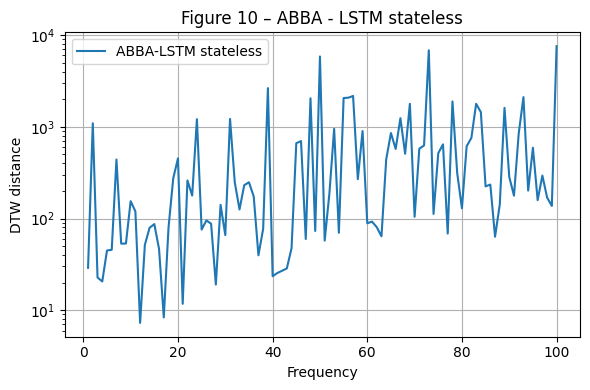

In [12]:
plt.figure(figsize=(6,4))
plt.plot(frequencies, dtw_abba, label="ABBA-LSTM stateless")
plt.xlabel("Frequency")
plt.yscale("log") 
plt.ylabel("DTW distance")
plt.title("Figure 10 – ABBA - LSTM stateless")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

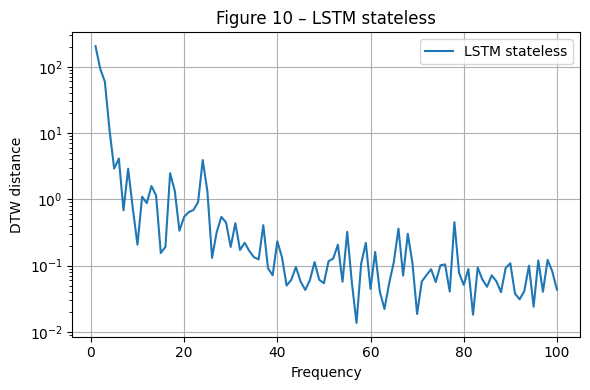

In [14]:
plt.figure(figsize=(6,4))
plt.plot(frequencies, dtw_lstm, label="LSTM stateless")
plt.xlabel("Frequency")
plt.yscale("log") 
plt.ylabel("DTW distance")
plt.title("Figure 10 – LSTM stateless")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 11

In [16]:
N = 200
lag = 20
p = 20
horizon = N // 2
n_runs = 5
series = np.array([t / N for t in range(N)], dtype=np.float32)
training = torch.tensor(series[:N // 2])
expected = series[N // 2:]
all_forecasts = []

for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    torch.manual_seed(run)
    np.random.seed(run)
    lstm_model = TimeSeriesLSTM(lag=lag, hidden_sizes=[50, 50])
    train_lstm_rolling(
        lstm_model,
        training,
        patience=p,
        lr=0.0005,
        epochs=300,
        val_size=30
    )
    forecast = lstm_model.forecast(
        training[-lag:],
        horizon=horizon
    ).cpu().numpy()
    all_forecasts.append(forecast)

all_forecasts = np.array(all_forecasts)

Run 1/5
Epoch [10/300] Train: 0.008506 Val: 0.077076
Epoch [20/300] Train: 0.005802 Val: 0.042149
Epoch [30/300] Train: 0.005039 Val: 0.053797
Early stopping à l'epoch 37 (best val loss = 0.036824)
Run 2/5
Epoch [10/300] Train: 0.042328 Val: 0.165766
Epoch [20/300] Train: 0.009047 Val: 0.029242
Epoch [30/300] Train: 0.005314 Val: 0.058602
Early stopping à l'epoch 38 (best val loss = 0.025468)
Run 3/5
Epoch [10/300] Train: 0.017957 Val: 0.101343
Epoch [20/300] Train: 0.005869 Val: 0.038899
Epoch [30/300] Train: 0.004625 Val: 0.049916
Early stopping à l'epoch 36 (best val loss = 0.022900)
Run 4/5
Epoch [10/300] Train: 0.023469 Val: 0.119850
Epoch [20/300] Train: 0.006766 Val: 0.028925
Epoch [30/300] Train: 0.004758 Val: 0.052047
Early stopping à l'epoch 38 (best val loss = 0.026830)
Run 5/5
Epoch [10/300] Train: 0.037246 Val: 0.152266
Epoch [20/300] Train: 0.008377 Val: 0.031293
Epoch [30/300] Train: 0.005181 Val: 0.057181
Early stopping à l'epoch 38 (best val loss = 0.024114)


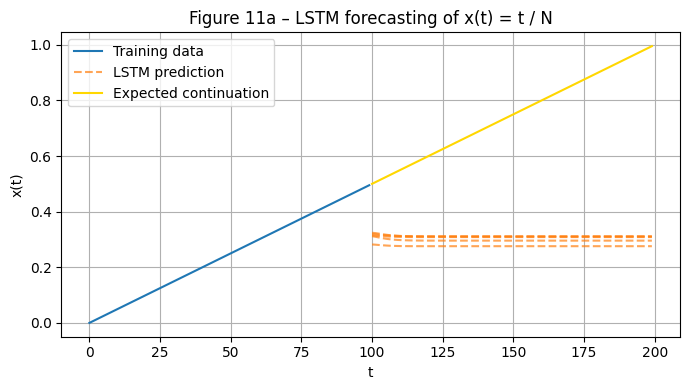

In [17]:
t_train = np.arange(len(training))
t_future = np.arange(len(training), N)

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    training.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    expected,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Figure 11a – LSTM forecasting of x(t) = t / N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
N = 200
lag = 3
p = 20
horizon = 100
n_runs = 1
series = [t / N for t in range(N)]
series = np.array(series) + 1e-2 * np.random.randn(len(series))
all_forecasts = []
training, expected = torch.tensor(series[:N // 2]), series[N // 2:]

for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    abba = ABBAPatched(compression_tol=0.01, alpha=0.1, max_k=4, random_state=run)
    training_sym = abba.fit(training)
    abba_model = ABBALSTM(n_symbols=abba.n_symbols, lag=lag)
    train_abba_rolling(abba_model, training_sym, patience=p, epochs=300, lr=0.0005, val_size=30)
    abba_forecast = abba_model.forecast(
        training_sym[-lag:],
        horizon=horizon
    )
    abba_forecast_num = abba.inverse_transform(abba_forecast, training[-1].item())
    abba_forecast_resampled = resample_to_horizon(
        abba_forecast_num,
        horizon
    )
    all_forecasts.append(abba_forecast_resampled)

Run 1/1
Epoch [10/300] Train: 1.377081 Val: 1.371127
Epoch [20/300] Train: 1.336687 Val: 1.340396
Epoch [30/300] Train: 1.279368 Val: 1.294872
Epoch [40/300] Train: 1.195684 Val: 1.229221
Epoch [50/300] Train: 1.100895 Val: 1.171286
Epoch [60/300] Train: 1.037887 Val: 1.156569
Epoch [70/300] Train: 0.994748 Val: 1.146262
Epoch [80/300] Train: 0.950589 Val: 1.137704
Epoch [90/300] Train: 0.896712 Val: 1.097442
Epoch [100/300] Train: 0.836446 Val: 1.047671
Epoch [110/300] Train: 0.775921 Val: 1.010684
Epoch [120/300] Train: 0.716931 Val: 0.997579
Epoch [130/300] Train: 0.660056 Val: 1.006169
Epoch [140/300] Train: 0.609392 Val: 1.042861
Early stopping à l'epoch 143 (best val loss = 0.996885)


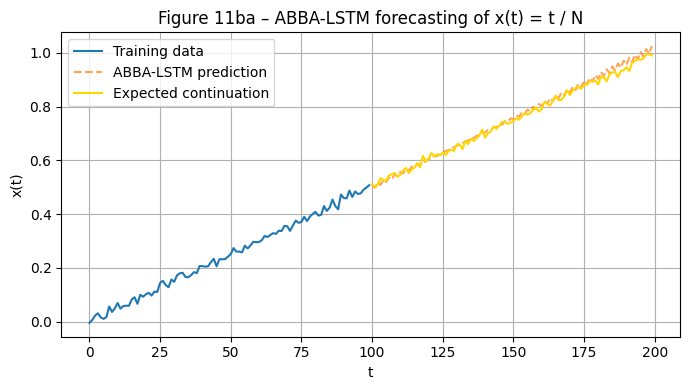

In [20]:
t_train = np.arange(len(training))
t_future = np.arange(len(training), N)

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    training.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="ABBA-LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    expected,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Figure 11ba – ABBA-LSTM forecasting of x(t) = t / N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 12

In [23]:
ts = [349,349,347,351,347,347,347,347,351,348,348,347,349,347,348,346,347,347,347,347,346,346,351,346,349,348,349,352,347,352,347,347,347,345,349,347,348,346,348,348,351,346,347,118,347,118,118,117,119,120,120,117,117,117,117,120,120,120,119,119,119,121,118,121,120,120,119,120,3060,120,3025,3022,3048,3034,3048,3048,3099,3099,3099,3095,3019,3095,3095,3083,3019,3019,3027,3083,3083,3016,3016,3016,3016,122,118,122,122,118,118,118,120,253,120,120,241,235,242,234,233,234,228,233,229,233,231,231,231,235,231,232,229,231,229,232,229,232,231,232,225,229,225,225,228,225,225,228,231,230,230,228,230,231,228,228,228,233,225,225,225,224,225,224,225,223,227,223,225,227,225,229,227,229,225,228,225,227,225,228,228,225,222,221,222,394,392,391,391,391,391,392,392,380,378,380,374,374,374,381,374,374,381,379,371,379,379,379,377,371,372,372,376,376,371,372,372,374,371,372,380,379,374,374,374,376,374,372,376,375,375,375,375,376,372,376,372,372,372,375,372,377,375,372,374,370,374,378,370,378,378,378,378,378,378,379,378,378,375,375,375,369,371,369,371,375,371,371,376,375,370,370,369,370,370,370,369,372,369,366,374,369,374,372,369,372,395,413,395,395,425,421,424,424,423,421,425,419,421,421,421,431,421,419,423,419,419,423,423,421,420,421,423,423,421,423,421,424,423,416,424,422,416,416,426,419,426,419,426,422,422,422,422,416,424,416,426,417,422,417,417,417,417,419,416,415,416,416,422,416,416,424,412,417,412,417,426,412,423,414,414,423,416,423,416,415,419,415,419,414,421,414,414,417,417,415,417,411,420,411,417,415,420,420,419,414,419,419,414,416,413,413,415,415,414,413,411,416,411,413,411,413,415,412,415,410,411,410,412,410,412,417,411,408,408,412,408,408,411,410,412,413,414,412,410,412,409,416,409,411,415,411,411,414,417,414,414,412,419,412,409,412,409,409,411,412,411,411,412,416,412,412,413,416,417,413,416,416,416,409,413,416,416,416,408,419,408,416,408,416,413,411,413,411,411,411,406,410,406,408,416,408,409,411,416,416,408,409,410,415,410,410,405,405,412,416,412,413,411,413,408,415,408,404,414,404,405,405,412,411,411,411,411,408,404,411,411,405,408,405,405,405,403,409,403,410,406,410,406,406,406,406,403,412,403,402,406,402,408,402,408,403,404,403,409,406,404,405,408,404,408,408,408,404,405,405,405,405,406,405,403,412,403,406,409,406,409,405,409,409,409,405,405,405,409,409,410,409,402,410,404,410,403,405,405,409,403,409,409,408,405,408,411,406,411,399,394,399,399,404,403,404,408,404,408,406,404,410,409,402,409,409,404,401,408,401,401,401,401,405,399,405,405,403,403,403,403,411,406,411,265,268,265,268,266,268,264,267,264,264,270,268,265,265,267,265,265,267,267,266,272,272,274,264,274,274,266,268,268,268,266,273,266,268,269,268,268,272,276,272,267,267,267,270,2606,270,2514,2501,2606,2606,2486,2486,2520,2465,2520,2520,2468,2496,2496,2488,2488,2488,2488,2522,2488,2471,2475,2471,2517,2472,2517,2517,2495,2497,2471,2471,2543,2485,2543,2543,2543,2474,2485,2485,2474,2478,2474,2510,2510,2540,2516,2540,2477,2517,2477,2538,2538,2538,2538,2538,2538,2538,2475,2503,2475,2480,2533,2480,2480,2539,2483,2539,2539,2543,2474,2483,2543,2532,2532,2498,2532,2511,2498,2473,2511,2529,2529,2519,2529,2541,2519,364,2541,2541,364,364,364,364,364,364,364,359,364,364,364,360,359,359,2484,2474,2481,2481,2479,2474,2479,2517,2486,2472,2467,2471,2471,2467,2474,2484,2474,2484,359,363,359,359,359,363,363,358,360,358,358,363,367,363,363,363,363,2488,363,2483,2477,2488,2531,2477,2531,2528,2477,2479,2543,2479,2543,2542,361,2509,357,359,357,357,363,365,363,363,361,357,361,364,366,364,359,360,358,358,358,358,2475,2468,2483,2526,2468,2526,2479,2479,2479,361,2479,365,364,365,364,359,364,357,365,357,358,363,358,363,363,357,363,356,2544,363,2480,2497,2480,2460,2508,2513,2472,2508,2469,358,2477,357,365,357,360,360,360,357,358,357,357,357,357,358,357,358,359,361,359,359,2484,364,2472,364,2523,2472,2486,2523,2533,2498,2498,2476,2472,2476,2476,2476,366,360,360,360,360,364,358,364,364,365,361,365,365,363,363,363,363,363,361,360,361,356,356,360,360,356,357,356,2488,2515,2515,2537,2638,2537,2537,2638,2675,2642,2708,2708,519,521,519,519,522,517,522,522,521,524,521,521,524,522,524,517,518,523,534,523,534,551,542,548,567,567,2713,2708,2700,2713,2680,2700,2762,2698,2698,561,560,561,523,512,523,523,507,512,512,525,525,525,525,614,634,610,610,627,627,627,627,650,627,627,627,650,654,654,2865,654,654,2850,2865]

train = torch.tensor(ts[600:900], dtype=torch.float)
test = torch.tensor(ts[900:1000], dtype=torch.float)

mean = train.mean()
std = train.std()
train_norm = (train - mean) / std
test_norm  = (test - mean) / std


In [24]:
N = len(train)
lag = 50
p = 100
horizon = len(test)
n_runs = 3
all_forecasts = []

for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    torch.manual_seed(run)
    np.random.seed(run)
    lstm_model = TimeSeriesLSTM(hidden_sizes=[50,50], lag=lag)
    train_lstm_rolling(
        lstm_model,
        train_norm,
        patience=p,
        lr=0.001,
        epochs=300,
        val_size=30
    )
    forecast = lstm_model.forecast(
        train_norm[-lag:],
        horizon=horizon
    ).cpu().numpy()
    all_forecasts.append(forecast)

all_forecasts = np.array(all_forecasts)

Run 1/3
Epoch [10/300] Train: 0.351488 Val: 0.484892
Epoch [20/300] Train: 0.243543 Val: 1.178809
Epoch [30/300] Train: 0.257519 Val: 1.157650
Epoch [40/300] Train: 0.218590 Val: 1.763764
Epoch [50/300] Train: 0.218350 Val: 2.052151
Epoch [60/300] Train: 0.196133 Val: 3.228396
Epoch [70/300] Train: 0.186291 Val: 3.443743
Epoch [80/300] Train: 0.192474 Val: 3.101813
Epoch [90/300] Train: 0.203028 Val: 2.853174
Epoch [100/300] Train: 0.209362 Val: 1.641214
Epoch [110/300] Train: 0.187909 Val: 3.794504
Epoch [120/300] Train: 0.175572 Val: 3.620236
Epoch [130/300] Train: 0.202794 Val: 3.495105
Epoch [140/300] Train: 0.186353 Val: 3.808640
Epoch [150/300] Train: 0.182510 Val: 4.045159
Epoch [160/300] Train: 0.176857 Val: 4.134120
Epoch [170/300] Train: 0.198066 Val: 3.540914
Early stopping à l'epoch 175 (best val loss = 0.304968)
Run 2/3
Epoch [10/300] Train: 0.379132 Val: 0.355893
Epoch [20/300] Train: 0.243296 Val: 1.145306
Epoch [30/300] Train: 0.233859 Val: 1.235509
Epoch [40/300] Train

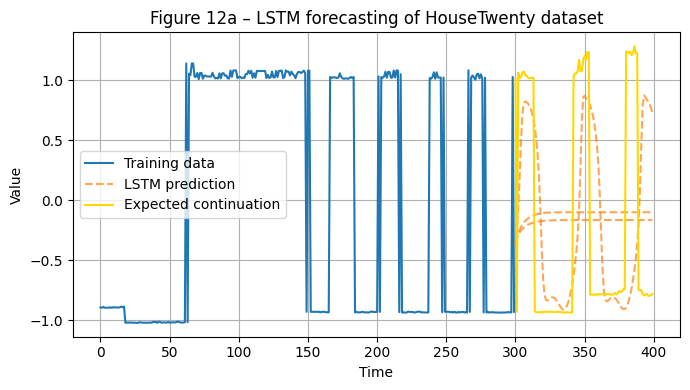

In [26]:
t_train = np.arange(len(train_norm))
t_future = np.arange(N, N + len(test_norm))

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    train_norm.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="LSTM prediction" if i==0 else None
    )

plt.plot(
    t_future,
    test_norm.numpy(),
    label="Expected continuation",
    color="gold"
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Figure 12a – LSTM forecasting of HouseTwenty dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
N = len(train)
lag = 5
p = 10
horizon = len(test)
n_runs = 1
all_forecasts = []

for run in range(n_runs):
    abba = ABBAPatched(compression_tol=0.01, alpha=0.3, max_k=5, random_state=run)
    training_sym = abba.fit(train)
    abba_model = ABBALSTM(hidden_sizes=[50,50], n_symbols=abba.n_symbols, lag=lag)
    train_abba_rolling(abba_model, training_sym, epochs=300, lr=0.0001, patience=p, val_size=30)
    abba_forecast = abba_model.forecast(
        training_sym[-lag:],
        horizon=horizon
    )
    abba_forecast_num = abba.inverse_transform(abba_forecast, train[-1].item())
    abba_forecast_resampled = resample_to_horizon(
        abba_forecast_num,
        horizon
    )
    all_forecasts.append(abba_forecast_resampled)

Epoch [10/300] Train: 1.408170 Val: 1.483965
Epoch [20/300] Train: 0.657761 Val: 1.160612
Epoch [30/300] Train: 0.547231 Val: 1.200691
Early stopping à l'epoch 30 (best val loss = 1.160612)


In [10]:
target_symbols = (1, 5)
tol = 0.01  # valeur de départ
alpha = 0.1
max_iter = 500

for _ in range(max_iter):
    abba = ABBAPatched(compression_tol=tol, alpha=alpha)
    training_sym = abba.fit(train)
    n_symbols = len(abba.patches)
    print(f"tol={tol:.4f}, alpha={alpha:.2f} -> {n_symbols} symboles")

    if target_symbols[0] <= n_symbols <= target_symbols[1]:
        break
    elif n_symbols < target_symbols[0]:
        tol *= 0.8  # segments trop gros, on diminue tol
        alpha *= 0.9
    else:
        tol *= 1.2  # segments trop petits, on augmente tol
        alpha *= 1.1


tol=0.0100, alpha=0.10 -> 102 symboles
tol=0.0120, alpha=0.11 -> 102 symboles
tol=0.0144, alpha=0.12 -> 102 symboles
tol=0.0173, alpha=0.13 -> 102 symboles


tol=0.0207, alpha=0.15 -> 102 symboles
tol=0.0249, alpha=0.16 -> 102 symboles
tol=0.0299, alpha=0.18 -> 102 symboles
tol=0.0358, alpha=0.19 -> 102 symboles
tol=0.0430, alpha=0.21 -> 102 symboles
tol=0.0516, alpha=0.24 -> 102 symboles
tol=0.0619, alpha=0.26 -> 102 symboles
tol=0.0743, alpha=0.29 -> 102 symboles
tol=0.0892, alpha=0.31 -> 102 symboles
tol=0.1070, alpha=0.35 -> 102 symboles
tol=0.1284, alpha=0.38 -> 102 symboles
tol=0.1541, alpha=0.42 -> 102 symboles
tol=0.1849, alpha=0.46 -> 102 symboles
tol=0.2219, alpha=0.51 -> 102 symboles
tol=0.2662, alpha=0.56 -> 102 symboles
tol=0.3195, alpha=0.61 -> 102 symboles
tol=0.3834, alpha=0.67 -> 102 symboles
tol=0.4601, alpha=0.74 -> 102 symboles
tol=0.5521, alpha=0.81 -> 108 symboles
tol=0.6625, alpha=0.90 -> 108 symboles
tol=0.7950, alpha=0.98 -> 109 symboles
tol=0.9540, alpha=1.08 -> 81 symboles
tol=1.1448, alpha=1.19 -> 81 symboles
tol=1.3737, alpha=1.31 -> 80 symboles
tol=1.6484, alpha=1.44 -> 79 symboles
tol=1.9781, alpha=1.59 -> 75 

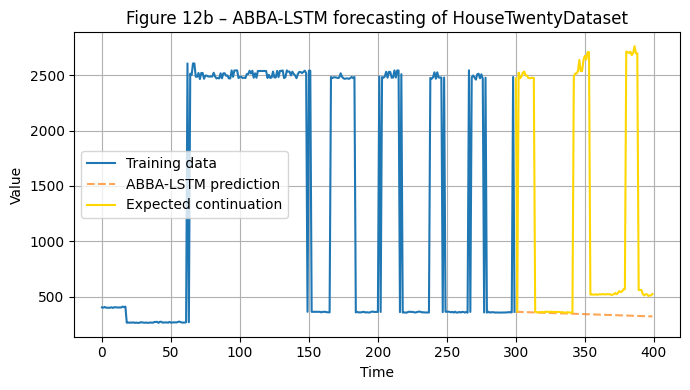

In [28]:
t_train = np.arange(len(train))
t_future = np.arange(N, N + len(test))

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    train.numpy(),
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="ABBA-LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    test,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Figure 12b – ABBA-LSTM forecasting of HouseTwentyDataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 14

In [ ]:
data = load_coffee()
X_train, X_test = data['data_train'], data['data_test']
y_train, y_test = data['target_train'], data['target_test']


In [3]:
horizon = 50
data = X_train[0]
# data = data[np.isnan(data)]
data = (data - np.mean(data)) / np.std(data)
train, test = data[:-horizon], data[-horizon:]

In [4]:
N = len(train)
lag = 5
p = 30
n_runs = 1
all_forecasts = []

In [5]:
for i in range(n_runs):
    abba = ABBAPatched(compression_tol=0.05, alpha=0.3, max_k=9, random_state=i)
    training_sym = abba.fit(train)
    abba_model = ABBALSTM(hidden_sizes=[16,16], n_symbols=len(abba.patches.keys()),lag=lag)
    train_abba_rolling(abba_model, training_sym, epochs=2000, lr=0.0001, patience=p, val_size=25)
    abba_forecast = abba_model.forecast(
        training_sym[-lag:],
        horizon=horizon
    )
    abba_forecast_num = abba.inverse_transform(abba_forecast, train[-1].item())
    abba_forecast_resampled = resample_to_horizon(
        abba_forecast_num,
        horizon
    )
    all_forecasts.append(abba_forecast_resampled)

First two features: [[-0.38600572 -0.21956956]
 [-0.10046724 -1.0869391 ]]
Distance: 0.9131605209742439
Alpha: 0.3
nb of clusters : 26
nb of clusters : 25
nb of clusters : 24
nb of clusters : 23
nb of clusters : 22
nb of clusters : 21
nb of clusters : 20
nb of clusters : 19
nb of clusters : 18
nb of clusters : 17
nb of clusters : 16
nb of clusters : 15
nb of clusters : 14
nb of clusters : 13
nb of clusters : 12
nb of clusters : 11
nb of clusters : 10
Epoch [10/2000] Train: 2.243077 Val: 2.263783
Epoch [20/2000] Train: 2.238218 Val: 2.259664
Epoch [30/2000] Train: 2.233402 Val: 2.255554
Epoch [40/2000] Train: 2.228602 Val: 2.251427
Epoch [50/2000] Train: 2.223785 Val: 2.247250
Epoch [60/2000] Train: 2.218919 Val: 2.242989
Epoch [70/2000] Train: 2.213970 Val: 2.238610
Epoch [80/2000] Train: 2.208910 Val: 2.234074
Epoch [90/2000] Train: 2.203707 Val: 2.229351
Epoch [100/2000] Train: 2.198328 Val: 2.224414
Epoch [110/2000] Train: 2.192743 Val: 2.219240
Epoch [120/2000] Train: 2.186917 Val:

In [ ]:

print(Counter(training_sym))


Counter({np.int64(0): 15, np.int64(5): 15, np.int64(2): 12, np.int64(3): 4, np.int64(4): 2, np.int64(6): 2, np.int64(8): 2, np.int64(1): 1, np.int64(7): 1})


In [7]:
abba.print_patches()

Symbol 0: length=4, delta=-0.13692528472506915
Symbol 1: length=25, delta=-0.22571157604170522
Symbol 2: length=7, delta=0.16900493845747142
Symbol 3: length=7, delta=0.6167749341470963
Symbol 4: length=4, delta=0.3232540691354968
Symbol 5: length=3, delta=0.09071264000680401
Symbol 6: length=10, delta=-0.41341340831984197
Symbol 7: length=8, delta=-0.8478375608606818
Symbol 8: length=4, delta=-0.6384081700928783


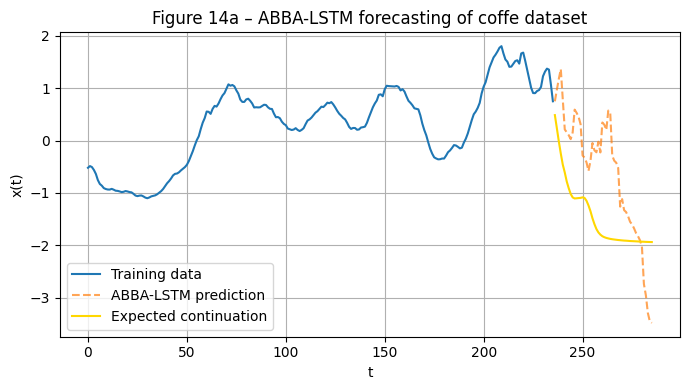

In [11]:
t_train = np.arange(len(train))
t_future = np.arange(N, N + len(test))

plt.figure(figsize=(7, 4))

plt.plot(
    t_train,
    train,
    label="Training data",
    color="tab:blue"
)

for i in range(n_runs):
    plt.plot(
        t_future,
        all_forecasts[i],
        "--",
        alpha=0.7,
        color="tab:orange",
        label="ABBA-LSTM prediction" if i == 0 else None
    )

plt.plot(
    t_future,
    test,
    label="Expected continuation",
    color="gold"
)

plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Figure 14a – ABBA-LSTM forecasting of coffe dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 16

In [3]:
from pyts.datasets import ucr_dataset_info

ucr_dataset_info(['GunPoint'])

{np.str_('GunPoint'): {'n_classes': 2,
  'n_timestamps': '150',
  'test_size': 150,
  'train_size': 50,
  'type': 'MOTION'}}

In [1]:
import shutil
import os

cache_dir = os.path.expanduser("~/.pyts_data")
shutil.rmtree(cache_dir, ignore_errors=True)


In [4]:
def plots(train, test, forecast, name):
    t_train = np.arange(len(train))
    t_future = np.arange(len(train), len(train) + len(test))

    plt.figure(figsize=(7, 4))

    plt.plot(
        t_train,
        train,
        label="Training data",
        color="tab:blue"
    )

    plt.plot(
        t_future,
        forecast,
        "--",
        alpha=0.7,
        color="tab:orange",
        label="ABBA-LSTM prediction"
    )

    plt.plot(
        t_future,
        test,
        label="Expected continuation",
        color="gold"
    )

    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.title(f"ABBA-LSTM forecasting of {name} dataset")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
ucr_dataset_list()

['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'BME',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'CBF',
 'Car',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGtorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'Earthquakes',
 'ElectricDevices',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

In [27]:
rm -rf ~/.pyts_data

ACSF1 skipped: File is not a zip file
Adiac skipped: File is not a zip file
AllGestureWiimoteX skipped: File is not a zip file
AllGestureWiimoteY skipped: File is not a zip file
AllGestureWiimoteZ skipped: File is not a zip file
ArrowHead skipped: File is not a zip file
BME skipped: File is not a zip file
Beef skipped: File is not a zip file
BeetleFly skipped: File is not a zip file
BirdChicken skipped: File is not a zip file
CBF skipped: File is not a zip file
Car skipped: File is not a zip file
Chinatown skipped: File is not a zip file
ChlorineConcentration skipped: File is not a zip file
CinCECGtorso skipped: File is not a zip file
First two features: [[-0.43165206 -0.24179823]
 [-0.15135851 -1.11914585]]
Distance: 0.9210338385972601
Alpha: 0.2
nb of clusters : 34
nb of clusters : 33
nb of clusters : 32
nb of clusters : 31
nb of clusters : 30
nb of clusters : 29
nb of clusters : 28
nb of clusters : 27
nb of clusters : 26
nb of clusters : 25
nb of clusters : 24
nb of clusters : 23
nb

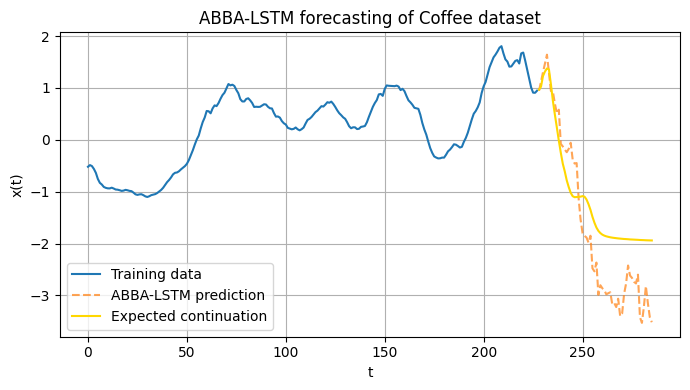

Coffee                    | sMAPE= 52.58 | DTW=   37.18 | time=  2.01s
Computers skipped: File is not a zip file
CricketX skipped: File is not a zip file
CricketY skipped: File is not a zip file
CricketZ skipped: File is not a zip file
Crop skipped: File is not a zip file
DiatomSizeReduction skipped: File is not a zip file
DistalPhalanxOutlineAgeGroup skipped: File is not a zip file
DistalPhalanxOutlineCorrect skipped: File is not a zip file
DistalPhalanxTW skipped: File is not a zip file
DodgerLoopDay skipped: File is not a zip file
DodgerLoopGame skipped: File is not a zip file
DodgerLoopWeekend skipped: File is not a zip file
ECG200 skipped: File is not a zip file
ECG5000 skipped: File is not a zip file
ECGFiveDays skipped: File is not a zip file
EOGHorizontalSignal skipped: File is not a zip file
EOGVerticalSignal skipped: File is not a zip file
Earthquakes skipped: File is not a zip file
ElectricDevices skipped: File is not a zip file
EthanolLevel skipped: File is not a zip file
F

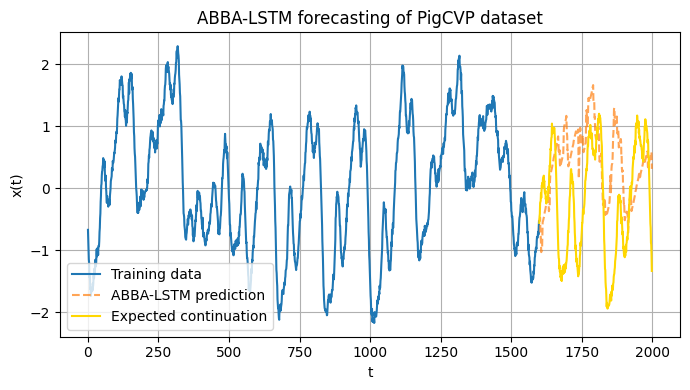

PigCVP                    | sMAPE=135.59 | DTW=  179.03 | time= 36.05s
Plane skipped: File is not a zip file
PowerCons skipped: File is not a zip file
ProximalPhalanxOutlineAgeGroup skipped: File is not a zip file
ProximalPhalanxOutlineCorrect skipped: File is not a zip file
ProximalPhalanxTW skipped: File is not a zip file
RefrigerationDevices skipped: File is not a zip file
Rock skipped: File is not a zip file
ScreenType skipped: File is not a zip file
SemgHandGenderCh2 skipped: File is not a zip file
SemgHandMovementCh2 skipped: File is not a zip file
SemgHandSubjectCh2 skipped: File is not a zip file
ShakeGestureWiimoteZ skipped: File is not a zip file
ShapeletSim skipped: File is not a zip file
ShapesAll skipped: File is not a zip file
SmallKitchenAppliances skipped: File is not a zip file
SmoothSubspace skipped: File is not a zip file
SonyAIBORobotSurface1 skipped: File is not a zip file
SonyAIBORobotSurface2 skipped: File is not a zip file
StarlightCurves skipped: File is not a 

In [17]:
results = []

for name in ucr_dataset_list():
    try:
        data = fetch_ucr_dataset(name, use_cache=True)
        X = data['data_train']

        # ignorer datasets trop courts
        if X.shape[1] < 200:
            continue

        series = X[0]

        series = (series - np.mean(series)) / np.std(series)

        # split temporel
        split = int(0.8 * len(series))
        train = series[:split]
        test = series[split:]

        horizon = len(test)

        start_time = time.perf_counter()

        # === ABBA + LSTM ===
        abba = ABBAPatched(compression_tol=0.05, alpha=0.2, max_k=9)
        sym_train = abba.fit(train)

        model = ABBALSTM(n_symbols=len(abba.patches), lag=10)
        train_abba_rolling(
            model,
            sym_train,
            epochs=500,
            train_size=len(sym_train)-30,
            val_size=30,
            patience=20,
            lr=0.0005
        )

        sym_forecast = model.forecast(sym_train[-10:], horizon)
        forecast = abba.inverse_transform(sym_forecast, train[-1])
        forecast_resized = resample_to_horizon(forecast, horizon)
        
        elapsed = time.perf_counter() - start_time

        plots(train, test, forecast_resized, name)

        # ===== METRICS =====
        smape_val = smape(test, forecast_resized)
        dtw_val = dtw(test, forecast_resized, keep_internals=False).distance

        results.append({
            "dataset": name,
            "smape": smape_val,
            "dtw": dtw_val,
            "time": elapsed
        })

        print(
            f"{name:25s} | "
            f"sMAPE={smape_val:6.2f} | "
            f"DTW={dtw_val:8.2f} | "
            f"time={elapsed:6.2f}s"
        )

    except Exception as e:
        print(f"{name} skipped: {e}")



In [18]:
results

[{'dataset': 'Coffee',
  'smape': np.float64(52.580200950759426),
  'dtw': np.float64(37.17971299270693),
  'time': 2.0057916869409382},
 {'dataset': 'PigCVP',
  'smape': np.float64(135.58809361357044),
  'dtw': np.float64(179.02695101096074),
  'time': 36.05032761301845}]

In [10]:
pyts/datasets/_cached_datasets

NameError: name 'pyts' is not defined